<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/rnn_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.11)  
baseline = 10
amplitude = 20
slope = 0
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)



#normalized_series = tf.keras.utils.normalize(series)[0]
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000



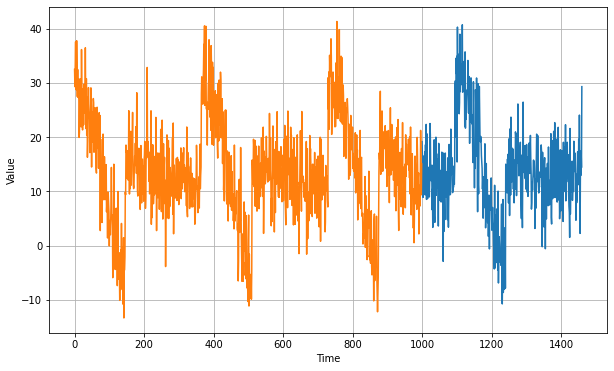

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_train, x_train)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 15
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.GRU(32, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5),
  tf.keras.layers.GRU(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu'), 
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100)
])


model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop())
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
31/31 [==============================] - 5s 150ms/step - loss: 11.9489
Epoch 2/100
31/31 [==============================] - 2s 53ms/step - loss: 8.9604
Epoch 3/100
31/31 [==============================] - 2s 53ms/step - loss: 7.5460
Epoch 4/100
31/31 [==============================] - 2s 52ms/step - loss: 7.0003
Epoch 5/100
31/31 [==============================] - 2s 53ms/step - loss: 6.5933
Epoch 6/100
31/31 [==============================] - 2s 55ms/step - loss: 6.5772
Epoch 7/100
31/31 [==============================] - 2s 52ms/step - loss: 6.3432
Epoch 8/100
31/31 [==============================] - 2s 53ms/step - loss: 6.3583
Epoch 9/100
31/31 [==============================] - 2s 54ms/step - loss: 6.1728
Epoch 10/100
31/31 [==============================] - 2s 53ms/step - loss: 5.8494
Epoch 11/100
31/31 [==============================] - 2s 54ms/step - loss: 5.9558
Epoch 12/100
31/31 [==============================] - 2s 56ms/step - loss: 5.8732
Epoch 13/100
31/31 [===

NameError: ignored

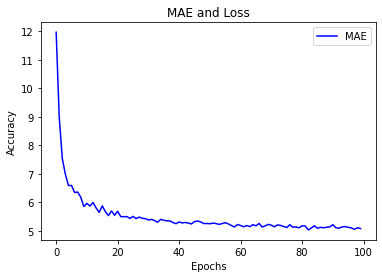

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
#mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[100:200]
mae_zoom = mae[100:200]
loss_zoom = loss[100:200]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

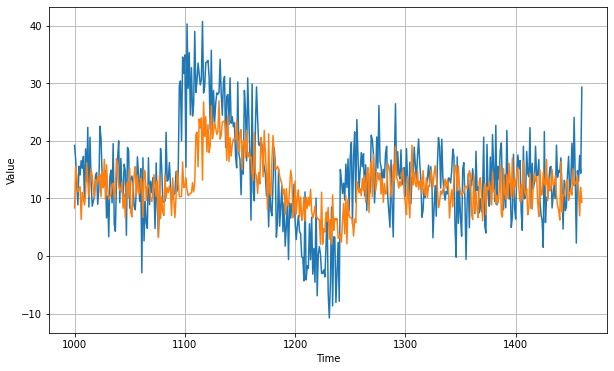

In [21]:
forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:,0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

array([ 7.7032714,  6.6154585,  6.337365 ,  6.6024446,  6.496149 ,
        6.414123 ,  8.9648075,  6.624142 ,  6.928907 ,  7.4393535,
        6.6485157,  6.8345985,  6.309987 ,  6.8454475,  6.3148265,
        6.5187263,  6.336268 ,  6.5042787,  6.930354 ,  6.309306 ,
        6.361281 ,  6.32742  ,  6.3116946,  6.36242  ,  6.8472633,
        6.4625373,  6.451573 ,  7.062836 ,  7.0196776,  6.7233834,
        6.4572496,  6.984887 ,  6.8269734,  6.7173667,  6.3663445,
        6.3368344,  6.9139557,  6.565369 ,  7.102392 ,  6.690647 ,
        6.3683295,  6.544281 ,  6.513651 ,  6.322295 ,  7.732887 ,
        6.7003264,  8.75908  ,  6.390474 ,  6.3191156,  6.8661885,
        6.5543303,  8.199891 ,  8.659786 ,  6.475731 ,  6.337672 ,
        6.619725 ,  6.8612666,  6.3429956,  6.598461 ,  6.6720405,
        6.3107576,  6.323851 ,  8.723459 ,  6.4867597,  6.4424267,
        7.07074  ,  6.413521 ,  6.3730116,  6.4760656,  6.9862866,
        7.1601686,  6.607532 ,  6.358807 ,  6.3603463,  6.8247